<a href="https://colab.research.google.com/github/hkaragah/risk_reliability/blob/main/PSHA_GR_Rupture_Boore1997GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSHA: Single GR Rupture Scenario with GMM Boore 1997

The considerations for this probabilistic seismic hazard analysis (PSHA) are as follows:

* Seimci source is capable of producing earthquakes with a variety of magnitudes that follows this bounded Gutenberg-Richter (GR) model:
  * $m_{min} = 5$
  * $m_{max} = 8$
  * $b = 1$
* Rate of earthauke is $\lambda(M\geq5)=0.05$ events annually
* Site is located at 10 km from this source
* The exceedance rate of an $SA(1s)$ is computed per Boore et al. 1997 groun-motion model (GMM)

## 1. Setting-up Working Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

working_dir = "/content/drive/MyDrive/Colab Notebooks/risk_reliability"
if not os.path.exists(working_dir):
  os.makedirs(working_dir)
os.chdir(working_dir)

## 2. Import Dependencies

In [3]:
import pandas as pd
from math import sqrt, log, exp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## 3. Gutenberg-Richter Distribution

The modern equivalent of the Gutenberg-Richter (GR) distribution is a boubly-bounded exponential distribution with the PDF function defined as:

$$
f_M(m) =
\begin{cases}
0, &&m<m_{min} \ \ \text{and} \ \ m>m_{max}\\
\\
\cfrac{\beta e^{-\beta (m - m_{min})}}{1-e^{-\beta (m_{max}-m_{min})}}, &&m_{min} \leq m \leq m_{max}
\end{cases}$$

and the CDF is defined as:

$$
F_M(m) =
\begin{cases}
0, &&m<m_{min}\\
\\
\cfrac{1-e^{-\beta(m - m_{min})}}{1-e^{-\beta(m_{max}-m_{min})}}, &&m_{min} \leq m \leq m_{max}\\
\\
1, &&m>m_{max}
\end{cases}$$



In [4]:
from typing import Protocol


class Magnitude(Protocol):
    def pdf(self, **kwargs) -> np.ndarray:
        ...

    def cdf(self, **kwargs) -> np.ndarray:
        ...


class Gutenberg_Richter(Magnitude):
    def __init__(self, m_min:float, m_max:float, b:float, step=0.01):
        self.m_min = m_min
        self.m_max = m_max
        self.beta = log(10) * b
        self.step = step
        self.m = np.arange(m_min + self.step/2, m_max - self.step/2, self.step)

    def pdf(self, **kwargs):
        m = kwargs.get('m', self.m)
        return self.beta * np.exp(-self.beta * (m - self.m_min)) / (1 - np.exp(-self.beta * (self.m_max - self.m_min)))

    def cdf(self, **kwargs):
        m = kwargs.get('m', self.m)
        return (1 - np.exp(-self.beta * (m - self.m_min))) / (1 - np.exp(-self.beta * (self.m_max - self.m_min)))

    def probability_of_occurrence(self) -> np.ndarray:
        return self.cdf(m = self.m + self.step/2) - self.cdf(m = self.m - self.step/2)

    def rate_of_occurrence(self, activity_rate) -> np.ndarray:
        return activity_rate * self.probability_of_occurrence()

    def rate_of_exceedance(self, activity_rate) -> np.ndarray:
        return np.flipud(np.flipud(self.rate_of_occurrence(activity_rate)).cumsum())

In [130]:
gr_dist = Gutenberg_Richter(m_min=5, m_max=8, b=1, step=0.2)

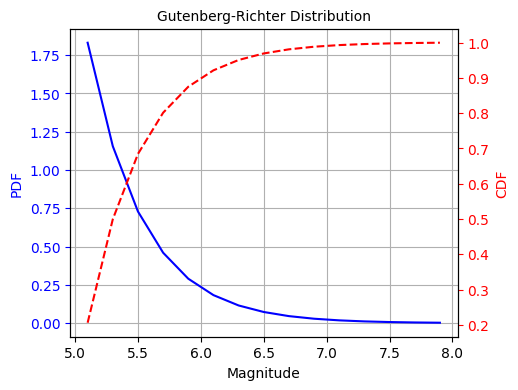

In [133]:
fig, ax1 = plt.subplots(figsize=(5,4))
ax1.plot(gr_dist.m, gr_dist.pdf(), 'b-', label="PDF")
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('PDF', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(gr_dist.m, gr_dist.cdf(), 'r--', label="CDF")
ax2.set_ylabel('CDF', color='r')
ax2.tick_params('y', colors='r')

plt.title('Gutenberg-Richter Distribution', fontsize=10)
ax1.grid()
plt.show()

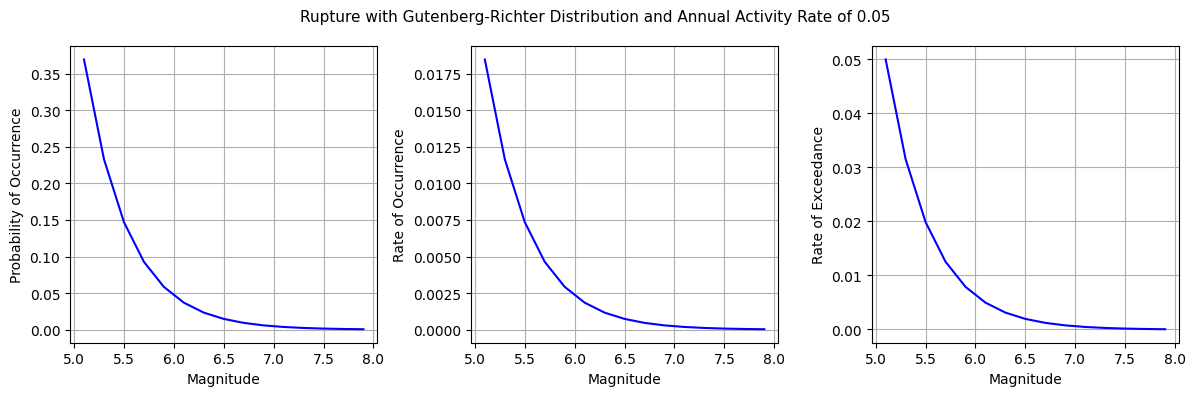

In [132]:
activity_rate = 0.05

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.lineplot(x=gr_dist.m, y=gr_dist.probability_of_occurrence(), ax=axes[0], color='b')
axes[0].set_ylabel('Probability of Occurrence')

sns.lineplot(x=gr_dist.m, y=gr_dist.rate_of_occurrence(activity_rate), ax=axes[1], color='b')
axes[1].set_ylabel('Rate of Occurrence')

sns.lineplot(x=gr_dist.m, y=gr_dist.rate_of_exceedance(activity_rate), ax=axes[2], color='b')
axes[2].set_ylabel('Rate of Exceedance')

for ax in axes:
    ax.set_xlabel('Magnitude')
    ax.grid(True)

fig.suptitle(f'Rupture with Gutenberg-Richter Distribution and Annual Activity Rate of {activity_rate}', fontsize=11)
fig.tight_layout()
plt.show()

## 5. Define Site and Ruptures

In [138]:
class Rupture():

    def __init__(self, rup_type:str, magnitude_dist:Magnitude, annual_activity_rate:float):
        self.rup_type = rup_type
        self.magnitude = magnitude_dist
        self.annual_activity_rate = annual_activity_rate

    def __str__(self) -> str:
        return f"{self.rup_type} rupture, M_min: {self.magnitude.m_min}, M_max: {self.magnitude.m_max}, rate: {self.annual_activity_rate} km"


class Site():

    def __init__(self, shear_velocity_m_sec:float):
        self.shear_velocity = shear_velocity_m_sec # Vs
        self.ruptures = []
        self.rup_dists = []

    def add_rupture(self, rupture:Rupture, distance_km:float):
        self.ruptures.append(rupture)
        self.rup_dists.append(distance_km)

    def __str__(self) -> str:
        rup_str = "\n".join([f"@ {dist}km -> {rup}" for rup, dist in zip(self.ruptures, self.rup_dists)])
        return f"Site: Vs {self.shear_velocity}\nRuptures:\n{rup_str if rup_str else 'None'}"

In [139]:
gr_dist1 = Gutenberg_Richter(m_min=5, m_max=8, b=1, step=0.2)
gr_dist2 = Gutenberg_Richter(m_min=5.5, m_max=8, b=1, step=0.2)
dist_km = 10

rup1 = Rupture(rup_type="strike-slip", magnitude_dist=gr_dist1, annual_activity_rate = 0.05)
rup2 = Rupture(rup_type="strike-slip", magnitude_dist=gr_dist2, annual_activity_rate = 0.01)

ruptures = [rup1, rup2]
distances = [10, 15]

site1 = Site(shear_velocity_m_sec = 500)

for rup, dist in zip(ruptures, distances):
    site1.add_rupture(rup, dist)

print(site1)

Site: Vs 500
Ruptures:
@ 10km -> strike-slip rupture, M_min: 5, M_max: 8, rate: 0.05 km
@ 15km -> strike-slip rupture, M_min: 5.5, M_max: 8, rate: 0.01 km


## 4. Boore et al. (1997) Ground-Motion Model (GMM)

1- __Reference__

David M. Boore, William B. Joyner, and Thomas E. Fumal, 1997, Equations for Estimating Horizontal Response Spectra and Peak Acceleration from Western North American Earethquakes: A Summary of recent Work, Seismological Research Letters, Vol. 68, No. 1, 128-153.

2- __Estimated physical parameter__

  - Peak ground acceleration (Horizontal)
  - Spectral acceleration (h=5%, T=0.1 to 2 sec) (Horizontal)



3- __Used strong motion data__

  - Area: Western North America
  - Type of earthquake: Shallow earthquake (which the fault rupture lies mainly above a depth of  20km)
  - Period: 1940 – 1992 years
  - Number of events: 19
  - Number of records: 271
  - Magnitude: 5.2 – 7.4
  - Epicentral distance: 0 – 118 km

4- __Style of faulting__

  - Strike-slip
  - Reverse-slip
  - Mechanism is not specified

5- __Ground condition__

Classified by the average S-wave velocity over 30 m from ground surface

6- __Definition of magnitude__

Moment magnitude

7- __Definition of source distance__

Closest horizontal distance to a point on the earth's surface that lies directly above the rupture.

8- __Definition of horizontal component__

Random horizontal component

9- __Applicability written in the paper__

The equations are to be used magnitude 5.5 - 7.5 and distance no greater than 80 km.

10- __Empirical attenuation formula__

$$\ln Y = b_1 + b_2(M-6) + b_3(M-6)^2 + b_5 \ln r + b_V \ln \frac{V_S}{V_A}$$

* $r=\sqrt{r_{jb}^2 + h^2}$

* $b_1 =
\begin{cases}
b_{1SS} &\text{for strike-slip earquake s}\\
b_{1RV} &\text{for reverse-slip earthquake s}\\
b_{1ALL} &\text{if mechanism not specified}
\end{cases}$

* $Y$: peak horizontal acceleration or pseudo acceleration response (g)

* $M$: moment magnitude

* $r_{jb}$: closest horizontal distance to the surface projection of the rupture plane (km)

* $V_S$: average shear wave velocity to 30 m (m/sec)

Standard Error:
* $\sigma_{\ln Y}^2 = \sigma_Y^2 + \sigma_e^2$
* $\sigma_{\ln Y}$: one-sigma value of the natural logarithm of the ground-motion value
* $\sigma_e^2$: earthquake-to-earthquake component of variability
* $\sigma_r^2$: all other components of variability
* $\sigma_r^2 = \sigma_1^2 + \sigma_c^2$
* $\sigma_1^2$: variance from the first stage of regression
* $\sigma_c^2$: correction needed to give the variance corresponding to the randomly-oriented horizontal component

<a href="https://iisee.kenken.go.jp/eqflow/reference/1_2.htm">Boore et al 1997 coefficients</a>

In [58]:
class Ground_Motion_Model(Protocol):
    def load_data(self, **kwargs) -> pd.DataFrame:
        ...

    @property
    def periods(self) -> np.ndarray:
        ...

    def median_ground_motion(self, **kwargs) -> tuple[np.ndarray, np.ndarray]:
        ...

class Boore_1997(Ground_Motion_Model):

    def __init__(self) -> None:
        """
          Boore et al. 1997 coefficients
          Reference: https://iisee.kenken.go.jp/eqflow/reference/1_2.htm
        """
        self.df: pd.DataFrame = self.load_data()


    def load_data(self, path:str='Boore_et_al_1997.csv', index_col:str='Period') -> pd.DataFrame:
        """Load GMM data from CSV."""
        df = pd.read_csv(path, header=0, index_col=index_col)
        df.drop([0], axis=0, inplace=True)
        df.index.name = index_col
        return df

    @property
    def periods(self)->np.ndarray:
        return self.df.index.values

    def median(self, shear_velocity_m_sec:float, magnitudes:np.ndarray, rup_type:str, dist_km:float)->tuple[np.ndarray, np.ndarray]:

        m = magnitudes.reshape(1,-1)
        r = np.sqrt(dist_km**2 + self.df['h']**2).to_numpy().reshape(-1,1)

        b2 = self.df['B2'].to_numpy().reshape(-1,1)
        b3 = self.df['B3'].to_numpy().reshape(-1,1)
        b5 = self.df['B5'].to_numpy().reshape(-1,1)
        bv = self.df['BV'].to_numpy().reshape(-1,1)
        va = self.df['VA'].to_numpy().reshape(-1,1)

        if rup_type.lower() == 'strike-slip':
            b1 = self.df['B1SS'].to_numpy().reshape(-1,1)
        elif rup_type.lower() == 'reverse-slip':
            b1 = self.df['B1RV'].to_numpy().reshape(-1,1)
        else:
            b1 = self.df['B1ALL'].to_numpy().reshape(-1,1)

        return np.exp(b1 + b2*(m-6) + b3*(m-6)**2 + b5*np.log(r) + bv*np.log(shear_velocity_m_sec/va))

    def standard_deviation(self)->np.ndarray:
        return self.df['slnY'].to_numpy()

In [59]:
gmm = Boore_1997()

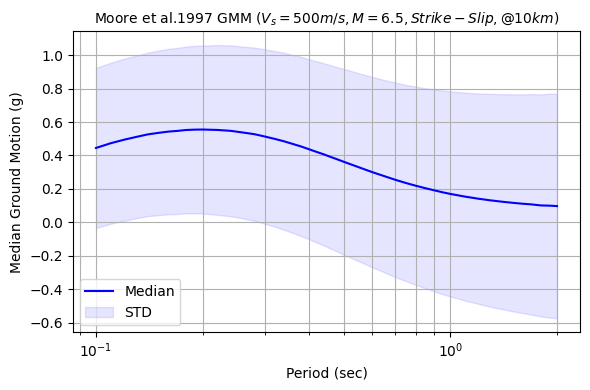

In [26]:
mag = gr.m[np.argmin(np.abs(gr.m-6.5))]
medians = gmm.median(shear_velocity_m_sec=site1.shear_velocity, magnitudes=mag, rup_type='strike-slip', dist_km=10)
stds = gmm.standard_deviation()

plt.figure(figsize=(6,4))
sns.lineplot(x=gmm.periods, y=medians.ravel(), color='b', label='Median')
plt.fill_between(gmm.periods, medians.ravel()-stds, medians.ravel()+stds, color='b', alpha=0.1, label="STD")
plt.xscale('log')
plt.xlabel('Period (sec)')
plt.ylabel('Median Ground Motion (g)')
plt.title(fr'Moore et al.1997 GMM ($V_s=500 m/s, M={mag:.1f}, Strike-Slip, @10 km$)', fontsize=10)
plt.legend(loc='lower left')
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [142]:
def probability_of_exceedance(site:Site, spectral_acceleration:np.ndarray, gmm:Ground_Motion_Model):
    result = []#np.empty((len(site.ruptures), len(gmm.periods), len(spectral_acceleration)))
    for rup, dist in zip(site.ruptures, site.rup_dists):
        medians = gmm.median(site.shear_velocity, rup.magnitude.m, rup.rup_type, dist).reshape(len(gmm.periods),-1,1)
        stds = gmm.standard_deviation().reshape(len(gmm.periods),1,1)
        proba = 1 - norm.cdf(np.log(spectral_acceleration), loc=np.log(medians), scale=stds)
        print(proba.shape)
        result.append(proba)
    return np.concatenate(result, axis=0)

# def annual_rate_of_exceedance(site, period:float, spectral_acceleration:np.ndarray, gmm:Ground_Motion_Model):
#     result = []
#     for rup, dist in zip(site.ruptures, site.rup_dists):
#         result.append(probability_of_exceedance(site, period, spectral_acceleration, gmm)[rupId] * rup['rup'].annual_activity_rate)
#     return result

In [124]:
rup1.magnitude.m

array([5.1, 5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5,
       7.7, 7.9])

In [143]:
# spectral_acceleration = np.linspace(5e-2, 2, 100)
a = probability_of_exceedance(site1, np.array([0.2, 0.5]), gmm)
print(a.shape)

(46, 15, 2)
(46, 12, 2)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 15 and the array at index 1 has size 12

In [119]:
medians = gmm.median(site1.shear_velocity, rup1.magnitude.m, rup1.rup_type,10).reshape(len(gmm.periods),-1,1)
stds = gmm.standard_deviation().reshape(-1,1,1)

In [120]:
print(medians.shape, stds.shape)

(46, 15, 1) (46, 1, 1)


In [122]:
1 - norm.cdf(np.log(np.array([0.2, 0.5])), loc=np.log(medians), scale=stds)[35,:,:]

array([[3.91982637e-03, 1.63597211e-05],
       [1.06061530e-02, 7.26555383e-05],
       [2.53715566e-02, 2.81948146e-04],
       [5.39960735e-02, 9.60932803e-04],
       [1.02918147e-01, 2.89128569e-03],
       [1.76940437e-01, 7.72080627e-03],
       [2.76505475e-01, 1.83980607e-02],
       [3.96045266e-01, 3.93430037e-02],
       [5.24672523e-01, 7.59460194e-02],
       [6.49210323e-01, 1.33160404e-01],
       [7.58135712e-01, 2.13467800e-01],
       [8.44534619e-01, 3.15082825e-01],
       [9.06923825e-01, 4.31436862e-01],
       [9.48094037e-01, 5.52461632e-01],
       [9.73014666e-01, 6.67240948e-01]])

In [93]:
(1 - norm.cdf(np.log(np.array([0.2, 0.5])), loc=np.log(medians), scale=stds)).shape

(46, 15, 2)

In [96]:
(1 - norm.cdf(np.log(np.array([0.2, 0.5])), loc=np.log(medians), scale=0.520))[35,:,:]

array([[8.60934251e-04, 4.87718605e-07],
       [3.30101603e-03, 3.76064777e-06],
       [1.06380739e-02, 2.40012562e-05],
       [2.90634136e-02, 1.27672933e-04],
       [6.79340794e-02, 5.70057597e-04],
       [1.37220158e-01, 2.15189821e-03],
       [2.42164914e-01, 6.91877323e-03],
       [3.77999061e-01, 1.90936897e-02],
       [5.29077880e-01, 4.55957781e-02],
       [6.74265123e-01, 9.50342941e-02],
       [7.95475255e-01, 1.74500165e-01],
       [8.83856933e-01, 2.85150924e-01],
       [9.40441497e-01, 4.19330309e-01],
       [9.72417061e-01, 5.61774566e-01],
       [9.88448326e-01, 6.94842463e-01]])